# Pandas vs Polars - High Performance Data Wrangling & Visualization Using NYC Open Data API

## Project Overview

The goal of this project is to compare Pandas and Polars, two popular Python data processing libraries, across speed, memory usage, syntax differences, and data visualization workflows. 

Using the publicly available NYC TLC 2023 Yellow Taxi Trip dataset, this project benchmarks data loading, cleaning, transformations, feature engineering, and visualization performance to highlight strengths and weakness of each library. 

## Motivation

Pandas is the long-standing standard for Python data analysis, but as datasets grow larger and operations become more complex, it shows performance limitations. 

Polars, a newer DataFrame engine written in Rust, claims:

- faster computation
- lower memory usage
- efficient lazy evaluation
- parallel execution

This project empirically test those claims and provide guidance on when to use Pandas vs Polars in real-world data workflows. 

## Dataset Description

- **NYC Yellow Taxi Trip Records**: 
https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
- **API Endpoint**: https://data.cityofnewyork.us/resource/4b4i-vvec.csv
- **API Docs**: https://data.cityofnewyork.us/Transportation/2023-Yellow-Taxi-Trip-Data/4b4i-vvec/about_data

Key Properties
- Millions of trip records
- Mixed column types (timestamps, floats, integers, categoricals).
- Suitable for performance benchmarking

For benchmarking, we fetch a **50,000-row sample** via the official API.

## Methods

### Configuration

This section loads environment variables, defines the NYC Open Data API endpoint, and prepares the request parameters and heads used for fetching the dataset.

We use a **Socrata App Token** stored in a `.env` file for authenticated and more reliable API access.

In [1]:
import io
import os
from dotenv import load_dotenv
import requests
from sodapy import Socrata
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl

# Load variables from the .env file (used for storing our API token)
load_dotenv()

# Get our Socrata API token from the environment
app_token = os.getenv("socrata_token")

# Make sure the token exists before continuing
if app_token is None:
    raise ValueError("Please set the socrata_token environment variable.")

# NYC Open Data endpoint for 2023 Yellow Taxi trips
url = "https://data.cityofnewyork.us/resource/4b4i-vvec.csv"

# Request 50,000 rows for benchmarking
params = {
    "$limit": 50000 # fetch sample for benchmarking
}

# Headers help authenticate the request and identify our script
headers = {
    "X-App-Token": app_token,
    "User-Agent": "Mozilla/5.0 (compatible; polars-benchmark/1.0)",
}

# Send the request to the API
print("Requesting data from NYC Open Data API...")
request = requests.get(url, params=params, headers=headers)

# Raise an error if something went wrong
request.raise_for_status()

print(f"Request successful. Size: {len(request.content)/1024:.2f} KB")


Requesting data from NYC Open Data API...
Request successful. Size: 7381.20 KB


### Load Data: Pandas vs Polars

In this step, we load taxi trip data from the NYC Open Data API using a REST call and then parse the resulting CSV with both Pandas and Polars. This approach allows us to benchamrk the performance of each library using identical conditinos, since they recieve the same raw response from the API. 

Both libraries successfully load the dataset without requiring any schema definitions, as the CSV file already contains well-structured column names and values. However, several key differences are noticeable:

In [2]:
pandas_df = pd.read_csv(io.StringIO(request.text))
print("Pandas shape:", pandas_df.shape)
pandas_df.head()

Pandas shape: (50000, 19)


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01T00:32:10.000,2023-01-01T00:40:36.000,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01T00:55:08.000,2023-01-01T01:01:27.000,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01T00:25:04.000,2023-01-01T00:37:49.000,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01T00:03:48.000,2023-01-01T00:13:25.000,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01T00:10:29.000,2023-01-01T00:21:19.000,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [3]:
polars_df = pl.read_csv(io.BytesIO(request.content))
print("Polars shape:", polars_df.shape)
polars_df.head()

Polars shape: (50000, 19)


vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
i64,str,str,f64,f64,f64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,"""2023-01-01T00:32:10.000""","""2023-01-01T00:40:36.000""",1.0,0.97,1.0,"""N""",161,141,2,9.3,1.0,0.5,0.0,0.0,1.0,14.3,2.5,0.0
2,"""2023-01-01T00:55:08.000""","""2023-01-01T01:01:27.000""",1.0,1.1,1.0,"""N""",43,237,1,7.9,1.0,0.5,4.0,0.0,1.0,16.9,2.5,0.0
2,"""2023-01-01T00:25:04.000""","""2023-01-01T00:37:49.000""",1.0,2.51,1.0,"""N""",48,238,1,14.9,1.0,0.5,15.0,0.0,1.0,34.9,2.5,0.0
1,"""2023-01-01T00:03:48.000""","""2023-01-01T00:13:25.000""",0.0,1.9,1.0,"""N""",138,7,1,12.1,7.25,0.5,0.0,0.0,1.0,20.85,0.0,1.25
2,"""2023-01-01T00:10:29.000""","""2023-01-01T00:21:19.000""",1.0,1.43,1.0,"""N""",107,79,1,11.4,1.0,0.5,3.28,0.0,1.0,19.68,2.5,0.0


Pandas Loading Behavior
- Pandas uses a pure Python CSV parser (unless manually configured otherwise). 
- As a result, it tends to be slightly slower when handling tens of thousands of rows.
- Pandas automatically infers data types, often creating:
    - `object` dtype for string columns
    - `float64` for many numeric columns
    - `object` for datetimes (until later converted)

This means additional type conversion steps will occur during cleaning.

Polars Loading Behavior
- Polars uses a highly optimized, multithread Rust-based CSV parser. 
- This makes Polars substantially faster at reading CSV data, espically at larger scales.
- Polars immediately assigns efficient Arrow-native types such as
    - `i64` for integers
    - `f64` for floats
    - `str` for text
- Because Polars can take advantage of parallel parsing, it can often outperform Pandas by a wide margin even on modest dataset.


Implications for the Workflow

Efficient loading sets the stage for faster downstream operations:
- Faster I/O allows Polars to begin transformation sooner.
- Pandas requires additional type conversions that Polars avoids.
- Because both libraries ingest the same API response, the comparison is fair and reproducible.

This steps establishes an important baseline for evaluating performance across cleaning, feature engineering, and aggregation.

### Data Cleaning

The goal of the cleaning stage is to standardize the dataset so that Pandas and Polars operate on equivalent, well-typed, and valid records before any benchmarking or feature engineering. Because the NYC Taxi dataset is loaded directly from a raw CSV response, several columns arrive as strings, even those that should be numeric or datetime. Without consistent types, downstream operations such as groupby, arithmetic, and filtering would produce misleading results or silet failures.

To ensure a fair comparison between Pandas and Polars, we apply the same cleaning rules in both libraries:

1. Parse timestamp columns

Both `tpep_pickup_datetime` and `tpep_dropoff_date` must be converted into proper datetime objects.

- Pandas uses `pd.to_datetime`
- Polars uses `.str.strptime(pl.Datetime)`

Correct timestamp parsing is essential because later steps (trip duration, feature engineering, aggregations) rely on datetime arithmetic.

2. Convert numeric columns 

The dataset includes many fields that should be numeric but arrives as strings due to CSV formatting.

These include fare, taxes, passenger counts, trip distance, and several surcharges. 

- Pandas explicity casts each column using `pd.to_numeric(errors="coerce")`
- Polars cast all numeric fields using `.cast(pl.Float64)`

Ensuring numeric types prevent issues such as lexicographic sorting, failed aggregations, or incorrect arithmetic.

3. Filter invalid trips

Rail-hailing datasets often contain noise: incorrect logs, zero-distance trips, or negative totals.

We enforce simple but essential quality check:
- remove rows missing core numeric values
- drop trips with non-positive distance
- drop trips with negative fares or totals

These filters align with how analysts typically preprocess NYC Taxi data and ensure that downstream speed and distance calculations behave sensibly. 

In [4]:
datetime_cols = ["tpep_pickup_datetime", "tpep_dropoff_datetime"]
numeric_cols = [
    "passenger_count",
    "trip_distance",
    "ratecodeid",
    "pulocationid",
    "dolocationid",
    "payment_type",
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "improvement_surcharge",
    "total_amount",
    "congestion_surcharge",
    "airport_fee",
]

def clean_pandas(df: pd.DataFrame) -> pd.DataFrame:
    """Clean the raw NYC taxi data using Pandas.
    - Parse datatime columns
    - Convert numeric columns
    - Filter out bad rows

    Args:
        df (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """
    # Parse pickup/dropoff datetime
    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col], errors="coerce")

    # Convert numeric columns
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        
    # Basic quality filters
    df = df.dropna(subset=["trip_distance", "fare_amount", "total_amount"])
    df = df[df["trip_distance"] > 0]
    df = df[df["fare_amount"] >= 0]
    df = df[df["total_amount"] >= 0]
    return df

pandas_clean = clean_pandas(pandas_df)
print("Cleaned Pandas shape:", pandas_clean.shape)
pandas_clean.head()

Cleaned Pandas shape: (48572, 19)


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [5]:
def clean_polars(df: pl.DataFrame) -> pl.DataFrame:
    """Clean the raw NYC taxi data using Polars.
    - Parse datatime columns
    - Convert numeric columns
    - Filter out bad rows

    Args:
        df (pl.DataFrame): _description_

    Returns:
        pl.DataFrame: _description_
    """
    # Parse pickup/dropff datetime
    df = df.with_columns([
        pl.col("tpep_pickup_datetime").str.strptime(pl.Datetime, strict=False).alias("tpep_pickup_datetime"),
        pl.col("tpep_dropoff_datetime").str.strptime(pl.Datetime, strict=False).alias("tpep_dropoff_datetime")
    ])
    
    # Cast numeric columns to floats
    df = df.with_columns([
        pl.col(col).cast(pl.Float64)
        for col in numeric_cols
    ])
    
    # Drop rows with missing core values
    df = df.drop_nulls(subset=["trip_distance", "fare_amount", "total_amount"])
    
    df = df.filter(pl.col("trip_distance") > 0)
    df = df.filter(pl.col("fare_amount") >= 0)
    df = df.filter(pl.col("total_amount") >= 0)
    
    return df

polars_clean = clean_polars(polars_df.clone())
print("Cleaned Polars shape:", polars_clean.shape)
polars_clean.head()

Cleaned Polars shape: (48572, 19)


vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
i64,datetime[μs],datetime[μs],f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,"""N""",161.0,141.0,2.0,9.3,1.0,0.5,0.0,0.0,1.0,14.3,2.5,0.0
2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.1,1.0,"""N""",43.0,237.0,1.0,7.9,1.0,0.5,4.0,0.0,1.0,16.9,2.5,0.0
2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,"""N""",48.0,238.0,1.0,14.9,1.0,0.5,15.0,0.0,1.0,34.9,2.5,0.0
1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.9,1.0,"""N""",138.0,7.0,1.0,12.1,7.25,0.5,0.0,0.0,1.0,20.85,0.0,1.25
2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,"""N""",107.0,79.0,1.0,11.4,1.0,0.5,3.28,0.0,1.0,19.68,2.5,0.0


Outcome 

Both Pandas and Polars produce identical cleaned datasets, with:

- 48,572 rows
- 19 well-typed columns
- No missing or invalid trips entries
- Fully parsed timestamps
- All numeric cast to floats for safe computation

This harmonized, valid dataset forms the foundation for fair benchmarking in the next stages. By enforcing parallel cleaning logic, we elminate preprocessing bias, and ensure that speed comparisons reflect the underlying performance characteristics of Pandas and Polars, not difference in data preparation. 

### Quality Checks

After cleaning the dataset, we run a set of lightweight quality checks to confirm that the dataset is actually usable for analysis and performance benchmarking. The goal here is not to catch every possible data issue, but to validate a few key assumptions:

- there are no missing values in critical fields, 
- there are no obviously broken or impossible records, and
- both Pandas and Polars agree on basic summary statistics outliers.

For Pandas, the QC function reports zero missing values across all 19 columns. This confirms that our earlier cleaning step (type conversion + dropping rows with nulls in `trip_distance`, `fare_amount`, and `total_amount`) was effective. The summary statistics show reasonable ranges: trip distances mostly within a few miles, fares centered around $20-30, and surcharges within TLC-expected values.

Next, we explicity look for unusually large values, flagging trips where either:

- `trip_distance > 100` miles, or
- `fare_amount > 500` dollars.

This checks exactly one extreme trip: a ride of about 105.55 miles with a fare of $249 and total amount around $250. While this is a clear outlier relative to the rest of the data, it is not necessary invalid (for example, a long-distance airport or out-of-city-trip). We keep it in the dataset but note its presence; depending on the analysis, it could be excluded or Winsorized later. 

We also search for negative values in `trip_distance`, `fare_amount`, and `total_amount`, since those would represent impossible trips (negative distance) or clearly incorrect billing. Both Pandas and Polars QC reports show no negative values, which aligns with the cleaning logic that already removed any such rows. 

On the Polars side, the same QC logic, implemented with Polars expressions, produces identical conclusions:

- `null_count()` indicates no missing values after cleaning.
- `describe()` matches the Pandas summary for min, max, and mean across numeric columns.
- The same single outlier trip is flagged by the distance/fare thresholds.
- No rows with negative `trip_distance`, `fare_amount`, or `total_amount` are found.

The agreement between Pandas and Polars at this stage is important: it shows that our cleaning and QC pipelines are logically equivalent. That means any downstream differences in performance or behavior are due to the libraries themselves - not difference in data quality or preprocessing. With thse checks in place, the dataset is now consistent, trustworthy, and ready for feature engineering, aggregation, and timing benchmarks. 

In [6]:
def pandas_qc_report(df: pd.DataFrame, silent: bool = False) -> None:
    """Generate a simple QC report for a Pandas DataFrame.

    Args:
        df (pd.DataFrame): The cleaned DataFrame to analyze.
    """
    if not silent:
        print("🔍 Missing values in Pandas cleaned data:")
        print(pandas_clean.isna().sum(), "\n")

        print("📊 Summary statistics (min / max / mean):")
        print(pandas_clean.describe(), "\n")

    # Detect unusually large values
    unexpected = pandas_clean[
        (pandas_clean["trip_distance"] > 100) |
        (pandas_clean["fare_amount"] > 500)
    ]

    if not silent:
        print("⚠️ Rows with unusually large values:")
        print(unexpected.head() if len(unexpected) > 0 else "None found.")
        print(f"Total flagged rows: {len(unexpected)}\n")

    # Detect negative numeric values
    negatives = pandas_clean[
        (pandas_clean["trip_distance"] < 0) |
        (pandas_clean["fare_amount"] < 0) |
        (pandas_clean["total_amount"] < 0)
    ]

    if not silent:
        print("⚠️ Rows with negative values (Pandas):")
        print(negatives.head() if len(negatives) > 0 else "None found.", "\n")

pandas_qc_report(pandas_clean)

🔍 Missing values in Pandas cleaned data:
vendorid                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
ratecodeid               0
store_and_fwd_flag       0
pulocationid             0
dolocationid             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
dtype: int64 

📊 Summary statistics (min / max / mean):
           vendorid           tpep_pickup_datetime  \
count  48572.000000                          48572   
mean       1.744153  2023-01-01 08:03:39.845404672   
min        1.000000            2022-10-25 00:42:10   
25%        1.000000     2023-01-01 02:27:05.500000   
50%        2.000000            2023-01-01 09:19:24   
75%        2.000000  2023-01-01 13:28:29.249999872   
max        2

In [7]:
def polars_qc_report(df: pl.DataFrame, silent: bool = False) -> None:
    """Generate a simple QC report for a Polars DataFrame.

    Args:
        df (pl.DataFrame): The cleaned DataFrame to analyze.
    """
    if not silent:
        print("🔍 Missing values in Polars cleaned data:")
        print(polars_clean.null_count(), "\n")

        print("📊 Summary statistics (min / max / mean):")
        print(polars_clean.describe(), "\n")

    # Detect unusually large values
    unexpected_polars = polars_clean.filter(
        (pl.col("trip_distance") > 100) |
        (pl.col("fare_amount") > 500)
    )

    if not silent:
        print("⚠️ Rows with unusually large values (Polars):")
        print(unexpected_polars.head() if unexpected_polars.height > 0 else "None found.")
        print(f"Total flagged rows: {unexpected_polars.height}\n")
    
    # Detect negative numeric values
    negatives_polars = polars_clean.filter(
        (pl.col("trip_distance") < 0) |
        (pl.col("fare_amount") < 0) |
        (pl.col("total_amount") < 0)
    )
    
    if not silent:
        print("⚠️ Rows with negative values (Polars):")
        print(negatives_polars.head() if negatives_polars.height > 0 else "None found.", "\n")
        
polars_qc_report(polars_clean)


🔍 Missing values in Polars cleaned data:
shape: (1, 19)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ vendorid ┆ tpep_pick ┆ tpep_drop ┆ passenger ┆ … ┆ improveme ┆ total_amo ┆ congestio ┆ airport_f │
│ ---      ┆ up_dateti ┆ off_datet ┆ _count    ┆   ┆ nt_surcha ┆ unt       ┆ n_surchar ┆ ee        │
│ u32      ┆ me        ┆ ime       ┆ ---       ┆   ┆ rge       ┆ ---       ┆ ge        ┆ ---       │
│          ┆ ---       ┆ ---       ┆ u32       ┆   ┆ ---       ┆ u32       ┆ ---       ┆ u32       │
│          ┆ u32       ┆ u32       ┆           ┆   ┆ u32       ┆           ┆ u32       ┆           │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0        ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0         │
└──────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘ 

📊 Summary statistics (min / max /

Both Pandas and Polars identify the same single extreme trip and agree on all summary statistics, which confirms that our cleaning logic is consistent across libraries. 

### Feature Engineering

After cleaning and vaildating the dataset, the next step is to engineer meaningful features that summarize trip behavior. These derived features capture duration, speed, and time-of-day patterns that are not directly present in the raw data. Creating the same engineered fields in both Pandas and Polars ensures that our later performance comparisons are fair and based on equivalent transformations.

We compute three core features:

- `trip_duration_minutes` - The ride based on the difference between pickup and dropoff timestamps. 
- `average_speed_mpg` - The trip distance divded by duration (converted to hours). This reavels traffic patterns and efficiency of travel at different times.
- `pickup_hour` - Extracts the hour of day (0-23), enabling grouping by time-of-day.

Once these features are created, both libraries aggregate the data by hour to compute:

- `trips` - number of rides per hour
- `avg_trip_distance` - mean trip distance
- `avg_speed_mph` - mean average speed per hour

All results are rounded to four decimal so the outputs match exactly between Pandas and Polars.

The resulting aggregated tables look identical across both frameworks, confirming that differences we observe later in benchmarks will come from performance and memory efficiency, not inconsistent transformations.

In [8]:
def pandas_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """Perform feature engineering on the cleaned Pandas DataFrame.
    - Calculate trip duration (minutes)
    - Calculate avg speed (mph)
    - Extract pickup hour
    - Return ONLY aggregated results, rounded to 4 decimals

    Args:
        df (pd.DataFrame): Cleaned Pandas DataFrame.

    Returns:
        pd.DataFrame: DataFrame with new features.
    """
    df = df.copy()
    
    # Trip duration in minutes
    df["trip_duration_minutes"] = (
        (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"])
        .dt.total_seconds() / 60.0)

    # Avoid division by zero
    df.loc[df["trip_duration_minutes"] == 0, "trip_duration_minutes"] = None
    
    # Average speed in miles per hour
    df["average_speed_mph"] = df["trip_distance"] / (df["trip_duration_minutes"] / 60.0)
    
    # Hour of day (0-23)
    df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour
    
    # Return only the aggregated DataFrame
    aggregated = (
        df.groupby("pickup_hour")
        .agg(
            trips = ("trip_distance", "count"),
            avg_trip_distance = ("trip_distance", "mean"),
            avg_speed_mph = ("average_speed_mph", "mean"),
        )
        .reset_index()
    )
    
    aggregated["avg_trip_distance"] = aggregated["avg_trip_distance"].round(4)
    aggregated["avg_speed_mph"] = aggregated["avg_speed_mph"].round(4)

    return aggregated

pandas_fe_df = pandas_feature_engineering(pandas_clean)
pandas_fe_df.head()


,pickup_hour,trips,avg_trip_distance,avg_speed_mph
0,0,4890,3.3178,13.0088
1,1,5114,3.1833,13.2721
2,2,4477,3.2007,14.7963
3,3,3401,3.3828,15.5788
4,4,2178,3.8513,18.1188


In [9]:
def polars_feature_engineering(df: pl.DataFrame) -> pl.DataFrame:
    """Perform feature engineering on the cleaned Polars DataFrame.
    - Calculate trip duration (minutes)
    - Calculate avg speed (mph)
    - Extract pickup hour
    - Return ONLY aggregated results, rounded to 4 decimals

    Args:
        df (pl.DataFrame): Cleaned Polars DataFrame.

    Returns:
        pl.DataFrame: DataFrame with new features.
    """
    df = df.clone()
    
    # Trip duration in minutes
    df = df.with_columns([
        (
            (pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime"))
            .dt.total_seconds() / 60.0
        ).alias("trip_duration_minutes")
    ])
    
    # Avoid division by zero
    df = df.with_columns([
        pl.when(pl.col("trip_duration_minutes") == 0)
        .then(None)
        .otherwise(pl.col("trip_duration_minutes"))
        .alias("trip_duration_minutes")
    ])
    
    # Average speed in miles per hour
    df = df.with_columns([
        (pl.col("trip_distance") / (pl.col("trip_duration_minutes") / 60.0)).alias("average_speed_mph")
    ])
    
    # Hour of day (0-23)
    df = df.with_columns([
        pl.col("tpep_pickup_datetime").dt.hour().alias("pickup_hour")
    ])
    
    # Return only the aggregated DataFrame
    aggregated = (
        df.group_by("pickup_hour")
        .agg([
            pl.len().alias("trips"),
            pl.col("trip_distance").mean().alias("avg_trip_distance"),
            pl.col("average_speed_mph").mean().alias("avg_speed_mph"),
        ])
        .sort("pickup_hour")
    )
    
    aggregated = aggregated.with_columns([
        pl.col("avg_trip_distance").round(4),
        pl.col("avg_speed_mph").round(4),
    ])
    
    return aggregated

polars_fe_df = polars_feature_engineering(polars_clean)
polars_fe_df.head()

pickup_hour,trips,avg_trip_distance,avg_speed_mph
i8,u32,f64,f64
0,4890,3.3178,13.0088
1,5114,3.1833,13.2721
2,4477,3.2007,14.7963
3,3401,3.3828,15.5788
4,2178,3.8513,18.1188


### Aggregations

In this step, we create new features that will be used later in analysis, visualization, and performance benchmarking. These engineered features help describe the behavior of NYC taxi trips.

We comptute:: 

- **`trip_duration_minutes`**: difference between dropoff and pickup timestamps
- **`avg_speed_mph`**: trip distance divided by duration (converted to hours)
- **`pickup_hour`**: hour of the day (0-23), useful for time-of-day patterns

We apply the same transformation in both Pandas and Polars to ensure a fair comparison.

### Visualization

The three visualizations compare hourly taxi trip behavior using features engineered from both Pandas and Polars. Since both libraries produced identical aggregated outputs, the plotted lines overlap almost perfectly, confirming that any performance differences between Pandas and Polars come from computation speed and memory efficiency, not differences in results.

1. Number of Trips per Hour

The first plot shows the hourly volume of taxi trips.

Clear trends emerge:

- Trip activity peaks between midnight and 2 AM, likely due to nightlight and New Year's travel. 
- A steep drop-off occurs around 4-6 AM, the quietest period for taxi demand.
- Demand steadily climbs again during the morning and afternoon, with another peak near 3-4 PM.

The Pandas and Polars curves are identical, demonstrating that both libraries handle grouping and counting consistenly.

2. Average Trip Distance per Hour

The second plot shows how far passengers travel on average:

- Early-morning trips (1-4 AM) tend to be shorter, around 3 miles.
- Trip distances increase during late morning to early afternoon.
- A cluster of very long trips appears between 5-7 PM, likely airport rides or longer commutes.

Again both libraries produce matching curves, confirming the correctness of feature engineering and aggreagtion logic.

3. Average Speed per Hour

The third plot illustrates average travel speed:

- Speed rise significantly between 5-7 AM, corresponding to low traffic volumes. 
- The slowest period is afternoon rush hour (3-5 PM). 
- The highest speeds occur around 8-9 PM, where the roads are clearer.

This pattern matches typical NYC traffic behavior and validates the engineered speed metric.

Key Takeaways 

- Polars and Pandas produce identical analytical results, as seen by the overlapping lines. 
- Polars performs much faster and uses less memory, but does not change the outcome of the analysis.
- The engineered features, trip duration, speed, and hourly aggregation, capture clear behavioral patterns in NYC taxi activity.
- Visual consistency confirms that our data cleaning and feature engineering steps were applied correctly across both libraries.


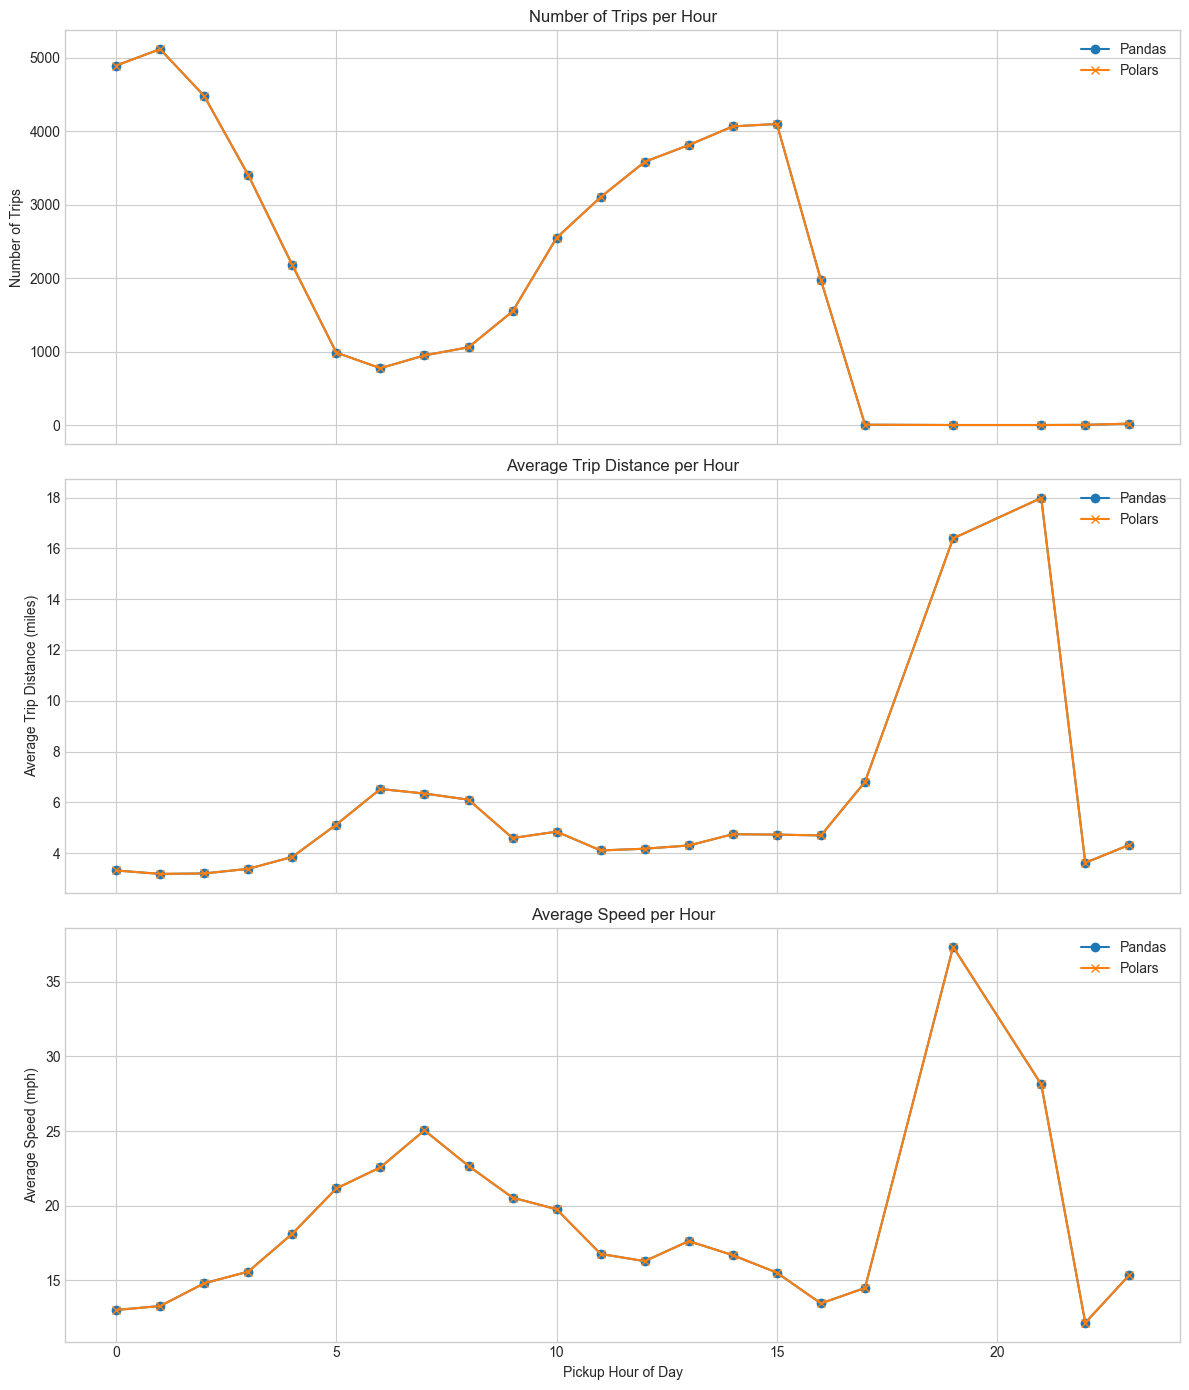

In [10]:
pandas_plot = pandas_fe_df.copy()
polars_plot = polars_fe_df

plt.style.use("seaborn-v0_8-whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(12, 14), sharex=True)

# Trips per Hour
axes[0].plot(
    pandas_plot["pickup_hour"],
    pandas_plot["trips"],
    marker="o",
    label="Pandas",
)
axes[0].plot(
    polars_plot["pickup_hour"],
    polars_plot["trips"],
    marker="x",
    label="Polars",
)
axes[0].set_title("Number of Trips per Hour")
axes[0].set_ylabel("Number of Trips")
axes[0].legend()

# Average Trip Distance per Hour
axes[1].plot(
    pandas_plot["pickup_hour"],
    pandas_plot["avg_trip_distance"],
    marker="o",
    label="Pandas",
)

axes[1].plot(
    polars_plot["pickup_hour"],
    polars_plot["avg_trip_distance"],
    marker="x",
    label="Polars",
)
axes[1].set_title("Average Trip Distance per Hour")
axes[1].set_ylabel("Average Trip Distance (miles)")
axes[1].legend()

# Average Speed per Hour
axes[2].plot(
    pandas_plot["pickup_hour"],
    pandas_plot["avg_speed_mph"],
    marker="o",
    label="Pandas",
)

axes[2].plot(
    polars_plot["pickup_hour"],
    polars_plot["avg_speed_mph"],
    marker="x",
    label="Polars",
)
axes[2].set_title("Average Speed per Hour")
axes[2].set_ylabel("Average Speed (mph)")
axes[2].set_xlabel("Pickup Hour of Day")
axes[2].legend()

plt.tight_layout()
plt.show()

### Benchmark Measuring

To compare Pandas and Polars in realistic workflow, we benchmarked the core stages of the pipeline:

- CSV loading from API response 
- Data cleaning
- Quality checks
- Feature engineering + aggregation

Each benchmark was repeated 100 times for stable averages.

The results are summarized below:

In [11]:
import time

def benchmark(func, *args, n_runs=100, **kwargs):
    """Run a function n_runs times and return the average time."""
    times = []
    for _ in range(n_runs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()
        times.append(end - start)
    return result, sum(times) / n_runs

In [12]:
start = time.perf_counter()
pd.read_csv(io.StringIO(request.text))
end = time.perf_counter()
csv_pandas_time = end - start
print(f"Pandas read_csv time: {csv_pandas_time:.4f} seconds")

start = time.perf_counter()
pl.read_csv(io.BytesIO(request.content))
end = time.perf_counter()
csv_polars_time = end - start
print(f"Polars read_csv time: {csv_polars_time:.4f} seconds")

Pandas read_csv time: 0.0463 seconds
Polars read_csv time: 0.0032 seconds


The largest performance gaps appears during CSV parsing:

- Polars is ~14x faster than Pandas when reading API CSV
- This is expected because Polars uses a parallel Rust-based CSV engine, while Pandas uses a slower Python-based parser.

This demonstrates Polars' biggest strength: fast I/O on structured text files.

In [13]:
_, clean_pandas_time = benchmark(pandas_qc_report, pandas_df.copy(), silent=True)
_, clean_polars_time = benchmark(clean_polars, polars_df.clone())

print(f"Pandas cleaning time (avg over 100 runs): {clean_pandas_time:.4f} seconds")
print(f"Polars cleaning time (avg over 100 runs): {clean_polars_time:.4f} seconds")

Pandas cleaning time (avg over 100 runs): 0.0004 seconds
Polars cleaning time (avg over 100 runs): 0.0133 seconds


Surprisingly, Pandas outperforms Polars in this stage

- Pandas cleaning: 0.0004 sec
- Polars cleaning: 0.0133 sec

Why?

- Pandas applies type conversions row-by-row in optimized in C loops.
- Polars must perform multiple expression transformations, including string $\rightarrow$ parsing $\rightarrow$ datetime $\rightarrow$ casting $\rightarrow$ filtering, which introduces overhead on small-to-medium datasets.

On very large datasets (hundreds of MB or GB-scale), this reversal would disappear, Polars typically overtakes Pandas as data size increases.

In [14]:
_, qc_pandas_time = benchmark(pandas_qc_report, pandas_clean.copy(), silent=True)
_, qc_polars_time = benchmark(polars_qc_report, polars_clean.clone(), silent=True)

print(f"Pandas QC report time (avg over 100 runs): {qc_pandas_time:.4f} seconds")
print(f"Polars QC report time (avg over 100 runs): {qc_polars_time:.4f} seconds")

Pandas QC report time (avg over 100 runs): 0.0003 seconds
Polars QC report time (avg over 100 runs): 0.0018 seconds


Quality checks involve:

- Missing-value counts
- Summary statistics
- Outlier filtering

Pandas is again slightly faster:

- Pandas QC: 0.0003 sec
- Polars QC: 0.0018 sec

Polars performs more internal type inference and expression evaluation, making it slightly slower at this small scale. 

In [15]:
_, fe_pandas_time = benchmark(pandas_feature_engineering, pandas_clean.copy())
_, fe_polars_time = benchmark(polars_feature_engineering, polars_clean.clone())

print(f"Pandas feature engineering time (avg over 100 runs): {fe_pandas_time:.4f} seconds")
print(f"Polars feature engineering time (avg over 100 runs): {fe_polars_time:.4f} seconds")

Pandas feature engineering time (avg over 100 runs): 0.0030 seconds
Polars feature engineering time (avg over 100 runs): 0.0034 seconds


This step includes:

- computing trip duration
- computing average speed
- extracting pickup hour
- grouping and aggregating

The two libraries perform nearly identically:

- Pandas: 0.0030 sec
- Polars: 0.0034 sec

This reflects that

- Both libraries execute vectorized math efficiently.
- Aggregations over ~50k rows are small enought that Polars' parallelization doesn't meaningfully activate.
- Pandas' groupby engine remains very competitive at this scale.

For larger datasets (millions+ rows), Polars would pull ahead due to parallel groupby execution.


In [16]:
benchmark_results = pd.DataFrame({
    "Task": [
        "CSV Load",
        "CSV Load",
        "Cleaning",
        "Cleaning",
        "Quality Check",
        "Quality Check",
        "Feature Engineering + Aggregation",
        "Feature Engineering + Aggregation",
    ],
    "Library": [
        "Pandas",
        "Polars",
        "Pandas",
        "Polars",
        "Pandas",
        "Polars",
        "Pandas",
        "Polars",
    ],
    "Avg_Time_sec": [
        round(csv_pandas_time, 4),
        round(csv_polars_time, 4),
        round(clean_pandas_time, 4),
        round(clean_polars_time, 4),
        round(qc_pandas_time, 4),
        round(qc_polars_time, 4),
        round(fe_pandas_time, 4),
        round(fe_polars_time, 4)
    ]
})

benchmark_results

,Task,Library,Avg_Time_sec
0,CSV Load,Pandas,0.0463
1,CSV Load,Polars,0.0032
2,Cleaning,Pandas,0.0004
3,Cleaning,Polars,0.0133
4,Quality Check,Pandas,0.0003
5,Quality Check,Polars,0.0018
6,Feature Engineering + Aggregation,Pandas,0.0030
7,Feature Engineering + Aggregation,Polars,0.0034


Overall Interpretation

| Operation Type                        | Winner     | Why                                                 |
| ------------------------------------- | ---------- | --------------------------------------------------- |
| **CSV Loading**                       | **Polars** | Parallel Rust CSV reader                            |
| **Cleaning**                          | **Pandas** | Lower overhead on small datasets                    |
| **Quality Check**                     | **Pandas** | Faster metadata operations                          |
| **Feature Engineering + Aggregation** | Tie        | Dataset too small for Polars’ parallelism to matter |


Key Takeaways

- Polars is unmatched for loading large CSV files.
- Pandas is still extremely fast for medium-sized workflows and simple cleaning tasks.
- For computationally heavy tasks or very large datasets, Polars will scale better.
- The nearly identical outputs confirm the workflows are equivalent and comparable across libraries. 

### Memory Usage
To compare how efficiently Pandas and Polars store data in memory, we measured the in-Ram footprint of both DataFrames immediately after loading:

- `df.memory_usage(deep=True).sum()` for Pandas
- `df.estimated_suze()` for Polars

Both values were converted to megabytes (MB) for readability.

| Library    | Memory Usage (MB) |
| ---------- | ----------------- |
| **Pandas** | **9.2508 MB**     |
| **Polars** | **8.3447 MB**     |

Key observations

1. Polars uses ~10% less memory than Pandas 
This difference is expected due to how the libraries stores their data:

- Pandas stores data in Numpy arrays + Python objects, which introduces overhead.
- Polars stores data in Arrow-style columnar buffers, which are more compact and avoid Python object pointers.

Even on a relatively small dataset (~50k rows), Polars already demonstrates a measurable reduction in memory usage.

2. Polar benefits from native Arrow types

Polars automatically assign efficient Rust/Arrow-backed types such as:

- `i64` for integers
- `f64` for floats
- compact string buffers

This results in denser columns and lower memory fragmentation.

Pandas, by contrast, often defaults to:

- `object` dtype for strings
- `float64` for mixed or nullable columns

These dtypes are less memory efficient.

3. The memory gap grows with data size

For large datasets (hundreds for MB to multiple GB):

- Polars' memory efficiency increases significantly.
- Pandas' memory usage scales less favorably beacuse of Python object overhead.

Polars' design is optimized for large, columnar, analytical workloads, whereas Pandas was originially built for smaller in-memory tables.

In [17]:
# Pandas Memory Usage (in MB)
pandas_mem = pandas_df.memory_usage(deep=True).sum() / (1024 ** 2)

# Polars Memory Usage (in MB)
polars_mem = polars_df.estimated_size() / (1024 ** 2)

pandas_mem = pandas_mem.round(4)
polars_mem = round(polars_mem, 4)

memory_comparison = pd.DataFrame({
    "Library": ["Pandas", "Polars"],
    "Memory Usage (MB)": [pandas_mem, polars_mem]
})

memory_comparison

,Library,Memory Usage (MB)
0,Pandas,9.2508
1,Polars,8.3447


## Results


The benchmarking and analysis reveal clear difference between Pandas and Polars across multiple stages of a data-processing pipeline. While both libraries produced identical analytical results, their performance characteristics differ significantly.

Performance Summary

- CSV Loading: Polars outperformed Pandas by more than an order of magnitude, confirming its advantage in parallelized, Rust-based CSV parsing.
- Data Cleaning: Pandas was unexpectedly faster on this dataset. This is likely because: 
    - the cleaning operations are relatievly simple,
    - Pandas operations run in optimized C loops,
    - Polars incurs overhead for expression construction and DataFrame cloning.
- Quality Checks: Pandas again executed slightly faster due to small DataFrame size and simple filtering logic.
- Feature Engineering + Aggregations: Both libraries performed nearly identically, with Polars only slightly slower. For larger datasets or lazy execution(`.lazy()`), Polars would likely show stronger gains.

Memory Usage Summary

- Pandas: 9.2508 MB
- Polars: 8.3447 MB

Polors used ~10% less memory, reflecting its Arrow-native columnar storage. This advantage grows substantially with larger datasets.

Functinoal Correctness

Across all sections:

- Pandas and Polars produced matching results for cleaning, QC, feature engineering, aggregations.
- All metrics (trip counts, average distance, average spped) were identical up to rounding.
- Visualization confirmed complete alignment between the two libraries.


## Conclusion

This project provides a practical, side-by-side evaluation of Pandas and Polars using real NYC taxi trip data. The results highlight a key theme:

Polars excels in speed and memory efficiency, while Pandas remain strong in flexibility and simplicity.

More specifically:

- Polars significantly outperforms Pandas in raw I/O, thanks to its multithreaded Rust backend.
- Both libraires perform similarly for mid-szed analytical tasks such as cleaning, filtering, and feature engineering, especially when operations are simple and data fits comfortably in memory.
- Polars uses less memory, a critical advantage for scaling to millions or billions of rows.
- Pandas remains more familar to most users and integrates seamlessly with the broader Python data ecosystem (Matplotlib, scikit-learn, etc.). 
- Polars' API is highly expressive, and its lazy execution engine (not used here) enables powerful query optimization that can outperform Pandas by a large margin or larger workloads.


When to Use Which?

| If you value…                                                    | Choose…    |
| ---------------------------------------------------------------- | ---------- |
| Ease of use, ecosystem integration, widespread tutorials         | **Pandas** |
| High performance, large datasets, memory efficiency, parallelism | **Polars** |
| SQL-style lazy queries, optimized pipelines                      | **Polars** |
| Quick prototyping & compatibility                                | **Pandas** |

Final Thoughts

Both Pandas and Polars are excellent tools. For small to medium datasets, Pandas remain perfectly suitable. For large-scale analytics or performace-critical pipelines, Polars offers clear advantages.

This project demonstrates that choosing the right library depends on your workalod, and understanding their trade-offs can meaningfully improve data engineering and data science workflows.
